In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7faf5a9af790>,
 'id': 1,
 'prcp': 0.08,
 'tobs': 65.0,
 'station': 'USC00519397',
 'date': '2010-01-01'}

In [10]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7faf5a9afdf0>,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1,
 'latitude': 21.2716,
 'elevation': 3.0}

In [9]:
# Find the most recent date in the data set.
most_recent = session.query(func.max(Measurement.date)).scalar()

print(most_recent)


2017-08-23


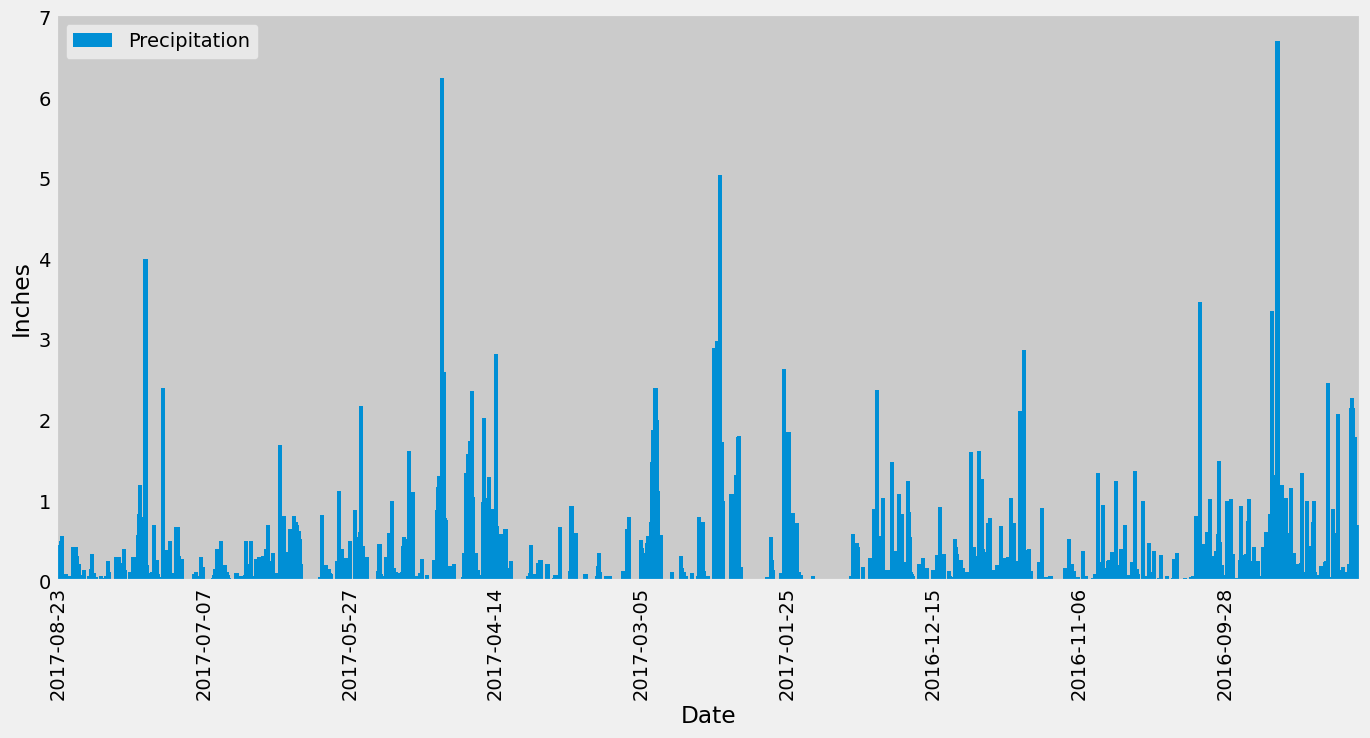

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# -- Calculate the date one year from the last date in the data set
date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# -- Perform a query to retrieve the data and precipitation scores for the last 12 months
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results)

# Sort the dataframe by date
df = df.sort_values(by='date', ascending=False)

df = df.rename({'prcp': 'Precipitation'}, axis='columns')

# Use Pandas Plotting with Matplotlib to plot the data
df= df.plot.bar(x='date', xlabel='Date', y='Precipitation', ylabel='Inches', figsize=(15,7), width=7)
xticks = df.xaxis.get_major_ticks()
for i,tick in enumerate(xticks):
    if i%250 != 0:
        tick.label1.set_visible(False);



In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_df = pd.DataFrame(df["Precipitation"].describe())
summary_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [26]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station).group_by(Station.station).count()
print(station_count)

unique_values = session.query(func.distinct(Station.station)).all()
value_counts = session.query(Station.station, func.count(Station.station)).group_by(Station.station).all()


9


In [31]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

result = session.query(Measurement.station, func.count().label('station_count')) \
    .group_by(Measurement.station) \
    .order_by(func.count().desc()) \
    .all()

# Print the result
for row in result:
    print(f"Station: {row.station}, Count: {row.station_count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [34]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_id = 'USC00519281'

result = session.query(func.min(Measurement.tobs).label('min_temp'),
                       func.max(Measurement.tobs).label('max_temp'),
                       func.avg(Measurement.tobs).label('avg_temp')) \
    .filter(Measurement.station == station_id).first()

print(f"Station: {station_id}")
print(f"Lowest Temperature: {result.min_temp}")
print(f"Highest Temperature: {result.max_temp}")
print(f"Average Temperature: {result.avg_temp}")

Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


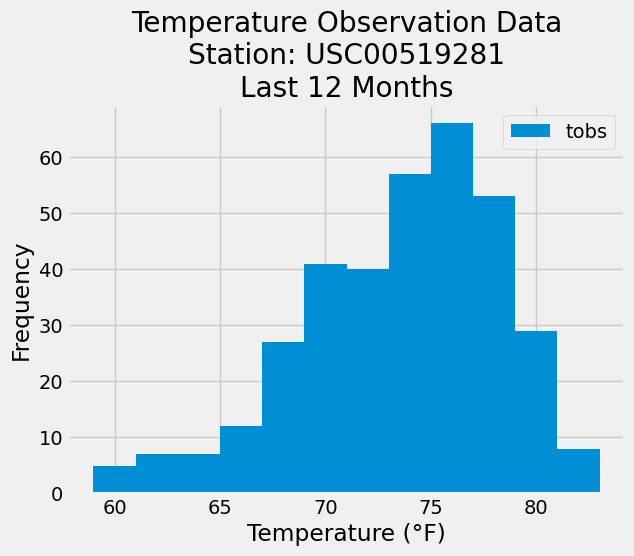

In [37]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results = session.query(Measurement.date, Measurement.tobs) \
    .filter(Measurement.station == station_id, Measurement.date >= date) \
    .all()
    
dates = [result.date for result in results]
temperatures = [result.tobs for result in results]

# Plot the histogram
plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observation Data\nStation: {station_id}\nLast 12 Months')
plt.legend()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()